In [1]:
import vireoSNP
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.io import mmread
from scipy.io import mmwrite
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mquad.mquad_utils import plot_confusionMatrix

print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


ss data loaded
scRNA data loaded
...scRNA done
...ssRNA done


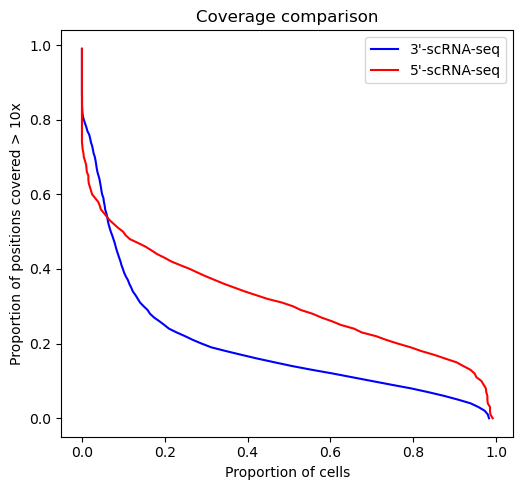

In [2]:
cell_vcf = vireoSNP.load_VCF("TNBC1_data/cellsnp/cellSNP.cells.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

#AD = cell_dat['AD']
ssRNA_DP = cell_dat['DP']
#variants=cell_vcf['variants']
print('ss data loaded')

cell_vcf = vireoSNP.load_VCF("5seq_data/cellsnp/cellSNP.cells.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

scRNA_DP = cell_dat['DP']
print('scRNA data loaded')


#percentage of cells with percentage of positions covered > 10x
prop_pos_scRNA = [scRNA_DP[:,i][scRNA_DP[:,i] >= 10].shape[1]/scRNA_DP.shape[0] for i in range(scRNA_DP.shape[1])]
print('...scRNA done')

prop_pos_ssRNA = [ssRNA_DP[:,i][ssRNA_DP[:,i] >= 10].shape[1]/ssRNA_DP.shape[0] for i in range(ssRNA_DP.shape[1])]
print('...ssRNA done')

prop_rna = np.array(prop_pos_scRNA)
prop_ssrna = np.array(prop_pos_ssRNA)
prop_cells_scRNA = [len(prop_rna[prop_rna > i/100])/len(prop_pos_scRNA) for i in range(100)]
prop_cells_ssRNA = [len(prop_ssrna[prop_ssrna > i/100])/len(prop_pos_ssRNA) for i in range(100)]


plt.style.use('default')
fig = plt.figure(figsize=(10,5), dpi=100)
ax = plt.subplot(1, 2, 1)
ax.plot(prop_cells_scRNA, np.array(range(100))/100, color='b', label="3'-scRNA-seq")
ax.plot(prop_cells_ssRNA, np.array(range(100))/100, color='r', label="5'-scRNA-seq")
#ax.plot(prop_cells_smart, np.array(range(100))/100, color='b', label = 'Smart-seq2 (Fibroblast)')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.title('Coverage comparison')
plt.xlabel('Proportion of cells')
plt.ylabel('Proportion of positions covered > 10x')
plt.legend(loc = 'upper right')
plt.tight_layout()
#plt.savefig('figures/coverage.pdf')

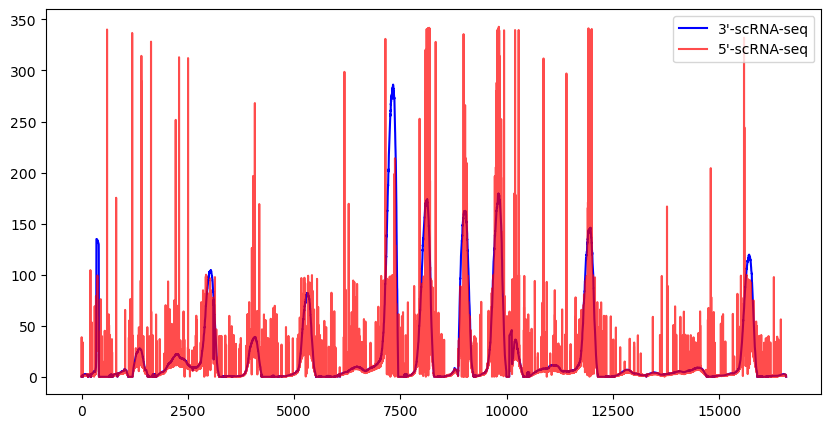

In [3]:
tnbc1 = pd.read_csv('TNBC1_data/cellsnp/mquad/BIC_params.csv')
tnbc1['pos'] = tnbc1.variant_name.apply(lambda x: int(x.split('_')[1]))
tnbc1_dp = tnbc1.sort_values(by='pos')[['total_DP', 'pos']]

melanoma = pd.read_csv('5seq_data/cellsnp/mquad/BIC_params.csv')
melanoma['pos'] = tnbc1.variant_name.apply(lambda x: int(x.split('_')[1]))
melanoma_dp = melanoma.sort_values(by='pos')[['total_DP', 'pos']]

fig = plt.figure(figsize=(10,5))
plt.plot(tnbc1_dp.pos, tnbc1_dp.total_DP/1097, color='blue', label="3'-scRNA-seq")
plt.plot(melanoma_dp.pos, melanoma_dp.total_DP/4680, color='red', alpha=0.7, label="5'-scRNA-seq")
plt.legend(loc='upper right')

In [4]:
AD = mmread('5seq_data/cellsnp/mquad/passed_ad.mtx').tocsc()
DP = mmread('5seq_data/cellsnp/mquad/passed_dp.mtx').tocsc()

from vireoSNP import BinomMixtureVB
_model = BinomMixtureVB(n_var=len(AD.getnnz(axis=1)), n_cell=len(AD.getnnz(axis=0)), n_donor=2)
_model.fit(AD, DP, min_iter=30, n_init=300)

modelCA = _model

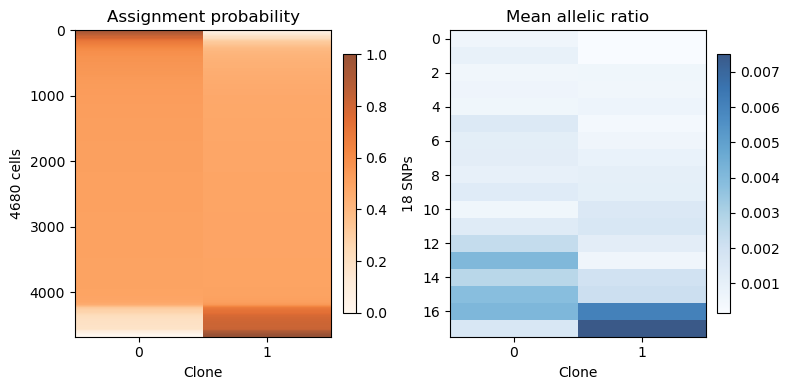

In [5]:
fig = plt.figure(figsize=(8,4))

from vireoSNP.plot.base_plot import heat_matrix
plt.subplot(1,2,1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))
plt.tight_layout()

plt.subplot(1,2,2)
AF_SNPs = modelCA.beta_mu
#rearrange clones to match fig 3b
#AF_SNPs_sorted = np.array([[i[1], i[2], i[0]]for i in AF_SNPs])
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))
plt.tight_layout()

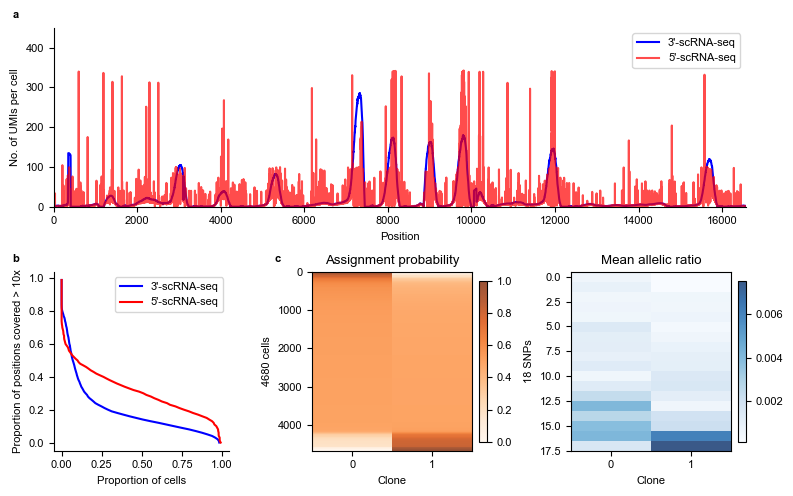

In [7]:
## put everything tgt
fig_grid_r = 2 #nrow
fig_grid_c = 3 #ncol

plt.style.use('default')
font = {'family' : 'Arial',
        'size'   : 8}
plt.rc('font', **font)

fig = plt.figure(figsize=(8,5))

ax = plt.subplot2grid((fig_grid_r, fig_grid_c), (0, 0), colspan=3, rowspan=1)
ax.text(-0.05, 1.1, 'a', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
ax.plot(tnbc1_dp.pos, tnbc1_dp.total_DP/1097, color='blue', label="3'-scRNA-seq")
ax.plot(melanoma_dp.pos, melanoma_dp.total_DP/4680, color='red', alpha=0.7, label="5'-scRNA-seq")
plt.legend(loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Position')
plt.ylabel('No. of UMIs per cell')
plt.xlim([0,16569])
plt.ylim([0,450])

ax = plt.subplot2grid((fig_grid_r, fig_grid_c), (1, 0), colspan=1, rowspan=1)
ax.text(-0.2, 1.1, 'b', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
ax.plot(prop_cells_scRNA, np.array(range(100))/100, color='b', label="3'-scRNA-seq")
ax.plot(prop_cells_ssRNA, np.array(range(100))/100, color='r', label="5'-scRNA-seq")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.plot(prop_cells_smart, np.array(range(100))/100, color='b', label = 'Smart-seq2 (Fibroblast)')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.xlabel('Proportion of cells')
plt.ylabel('Proportion of positions covered > 10x')
plt.legend(loc = 'upper right')
plt.tight_layout()

ax = plt.subplot2grid((fig_grid_r, fig_grid_c), (1, 1), colspan=1, rowspan=1)
ax.text(-0.2, 1.1, 'c', transform = ax.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))
plt.tight_layout()

ax = plt.subplot2grid((fig_grid_r, fig_grid_c), (1, 2), colspan=1, rowspan=1)
AF_SNPs = modelCA.beta_mu
#rearrange clones to match fig 3b
#AF_SNPs_sorted = np.array([[i[1], i[2], i[0]]for i in AF_SNPs])
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))
plt.tight_layout()

plt.savefig('figures/supp_5seq.pdf')